# imports

try to import all necessary 3rd party packages which are not already part of the default data science experience installation

note: If you are running outside data science experience you might need a "!pip install pandas scikit-learn tensorflow" 

In [1]:
!pip install keras --upgrade


Requirement already up-to-date: keras in /gpfs/global_fs01/cluster/yp-spark-lon02-env5-0101.bluemix.net/user/sba4-025109b8cbf0b6-2883b35da29d/.local/lib/python2.7/site-packages (2.2.4)
Requirement not upgraded as not directly required: scipy>=0.14 in /usr/local/src/bluemix_jupyter_bundle.v101/notebook/lib/python2.7/site-packages (from keras) (0.17.0)
Requirement not upgraded as not directly required: keras-preprocessing>=1.0.5 in /gpfs/global_fs01/cluster/yp-spark-lon02-env5-0101.bluemix.net/user/sba4-025109b8cbf0b6-2883b35da29d/.local/lib/python2.7/site-packages (from keras) (1.0.5)
Requirement not upgraded as not directly required: six>=1.9.0 in /usr/local/src/bluemix_jupyter_bundle.v101/notebook/lib/python2.7/site-packages (from keras) (1.10.0)
Requirement not upgraded as not directly required: numpy>=1.9.1 in /usr/local/src/bluemix_jupyter_bundle.v101/notebook/lib/python2.7/site-packages (from keras) (1.13.1)
Requirement not upgraded as not directly required: pyyaml in /usr/local/s

In [2]:
import pip

try:
    __import__('keras')
except ImportError:
    pip.main(['install', 'keras']) 
    
try:
    __import__('ibmiotf')
except ImportError:
    pip.main(['install', 'ibmiotf']) 

Using TensorFlow backend.


Now we import all the rest

In [3]:
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ibmiotf.application
import sys
from queue import Queue
import pandas as pd
import json
%matplotlib inline

We grab the files necessary for taining. Those are sampled from the lorenz attractor model implemented in NodeRED. Those are two serialized pickle numpy arrays

In [4]:
!rm watsoniotp.*
!wget https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.healthy.phase_aligned.pickle
!wget https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.broken.phase_aligned.pickle
!mv watsoniotp.healthy.phase_aligned.pickle watsoniotp.healthy.pickle
!mv watsoniotp.broken.phase_aligned.pickle watsoniotp.broken.pickle

--2018-12-31 14:01:40--  https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.healthy.phase_aligned.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194639 (190K) [text/plain]
Saving to: ‘watsoniotp.healthy.phase_aligned.pickle’

100%[======================================>] 194,639     --.-K/s   in 0.03s   

2018-12-31 14:01:40 (7.03 MB/s) - ‘watsoniotp.healthy.phase_aligned.pickle’ saved [194639/194639]

--2018-12-31 14:01:40--  https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.broken.phase_aligned.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request se

De-serialize the numpy array containing the training data

In [5]:
data_healthy = pickle.load(open('watsoniotp.healthy.pickle', 'rb'))
data_broken = pickle.load(open('watsoniotp.broken.pickle', 'rb'))

Reshape to three columns and 3000 rows. In other words three vibration sensor axes and 3000 samples

In [6]:
data_healthy = data_healthy.reshape(3000,3)
data_broken = data_broken.reshape(3000,3)

Since this data is sampled from the Lorenz Attractor Model, let's plot it with a phase lot to get the typical 2-eyed plot. First for the healthy data

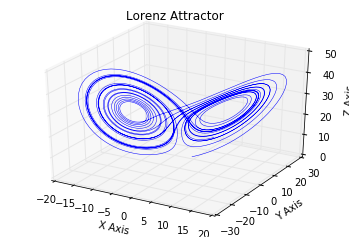

In [7]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(data_healthy[:,0], data_healthy[:,1], data_healthy[:,2],lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

Then for the broken one

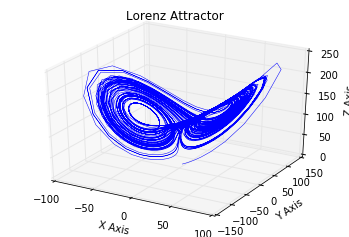

In [8]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(data_broken[:,0], data_broken[:,1], data_broken[:,2],lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

In the previous examples, we fed the raw data into an LSTM. Now we want to use an ordinary feed-forward network. So we need to do some pre-processing of this time series data

A widely-used method in traditional data science and signal processing is called Discrete Fourier Transformation. This algorithm transforms from the time to the frequency domain, or in other words, it returns the frequency spectrum of the signals.

The most widely used implementation of the transformation is called FFT, which stands for Fast Fourier Transformation, let’s run it and see what it returns


In [9]:
data_healthy_fft = np.fft.fft(data_healthy)
data_broken_fft = np.fft.fft(data_broken)

Let’s first have a look at the shape and contents of the arrays.

In [10]:
print (data_healthy_fft.shape)
print (data_healthy_fft)

(3000, 3)
[[  9.42619266+0.j          -1.59309633+0.51569445j
   -1.59309633-0.51569445j]
 [  9.90369920+0.j          -1.67640640+0.15919595j
   -1.67640640-0.15919595j]
 [ 10.43779318+0.j          -1.75331404-0.20569613j
   -1.75331404+0.20569613j]
 ..., 
 [ 24.96901270+0.j          -5.47609496+2.75768205j
   -5.47609496-2.75768205j]
 [ 25.97317526+0.j          -5.51210266+2.35412545j
   -5.51210266-2.35412545j]
 [ 27.08054148+0.j          -5.56743205+1.96286582j
   -5.56743205-1.96286582j]]


First, we notice that the shape is the same as the input data. So if we have 3000 samples, we get back 3000 spectrum values, or in other words 3000 frequency bands with the intensities.

The second thing we notice is that the data type of the array entries is not float anymore, it is complex. So those are not complex numbers, it is just a means for the algorithm the return two different frequency compositions in one go. The real part returns a sine decomposition and the imaginary part a cosine. We will ignore the cosine part in this example since it turns out that the sine part already gives us enough information to implement a good classifier.

But first let’s plot the two arrays to get an idea how a healthy and broken frequency spectrum differ


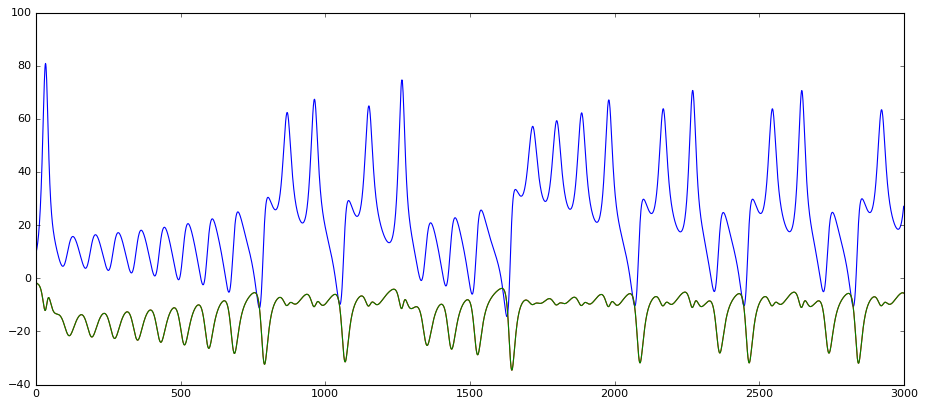

In [11]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.plot(range(0,size), data_healthy_fft[:,0].real, '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy_fft[:,1].real, '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy_fft[:,2].real, '-', color='green', animated = True, linewidth=1)

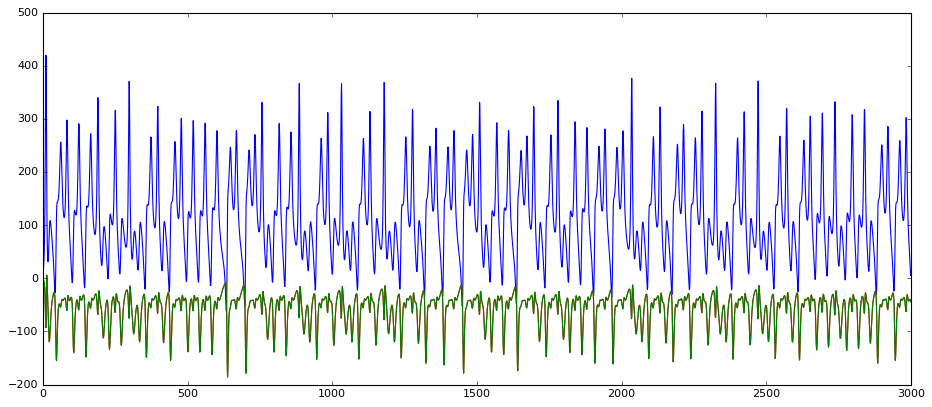

In [12]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.plot(range(0,size), data_broken_fft[:,0].real, '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken_fft[:,1].real, '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken_fft[:,2].real, '-', color='green', animated = True, linewidth=1)

So, what we've been doing is so called feature transformation step. We’ve transformed the data set in a way that our machine learning algorithm – a deep feed forward neural network implemented as binary classifier – works better. So now let's scale the data to a 0..1

In [13]:
def scaleData(data):
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data)

And please don’t worry about the warnings. As explained before we don’t need the imaginary part of the FFT

In [14]:
data_healthy_scaled = scaleData(data_healthy_fft)
data_broken_scaled = scaleData(data_broken_fft)

/usr/local/src/bluemix_jupyter_bundle.v101/notebook/lib/python2.7/site-packages/sklearn/utils/validation.py:373: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/src/bluemix_jupyter_bundle.v101/notebook/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype complex128 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/src/bluemix_jupyter_bundle.v101/notebook/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype complex128 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Now we reshape again to have three examples (rows) and 3000 features (columns). It's important that you understand this. We have turned our initial data set which containd 3 columns (dimensions) of 3000 samples. Since we applied FFT on each column we've obtained 3000 spectrum values for each of the 3 three columns. We are now using each column with the 3000 spectrum values as one row (training example) and each of the 3000 spectrum values becomes a column (or feature) in the training data set

In [15]:
data_healthy_scaled.shape = (3, 3000)
data_broken_scaled.shape = (3, 3000)

In [16]:
!rm -f rklib.py
!wget https://raw.githubusercontent.com/romeokienzler/developerWorks/master/coursera/ai/rklib.py

--2018-12-31 14:01:42--  https://raw.githubusercontent.com/romeokienzler/developerWorks/master/coursera/ai/rklib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2289 (2.2K) [text/plain]
Saving to: ‘rklib.py’

100%[======================================>] 2,289       --.-K/s   in 0s      

2018-12-31 14:01:42 (22.2 MB/s) - ‘rklib.py’ saved [2289/2289]



Please specify you email address you are using with cousera here:

In [17]:
from rklib import submit, submitAll
key = "4vkB9vnrEee8zg4u9l99rA"
all_parts = ["O5cR9","0dXlH","ZzEP8"]

email = "revanthrex1001@gmail.com"

In [18]:
dim = 3000
samples = 3

In [19]:
part = "O5cR9"
secret = "88LjDicrPoDGLPsv"

submitAll(email, secret, key, dict((p, json.dumps({}) if p != part else json.dumps({"dim": dim, "samples": samples})) for p in all_parts))

Something went wrong, please have a look at the reponse of the grader
-------------------------
{"errorCode":"invalidEmailOrToken","message":"Invalid email or token.","details":{"learnerMessage":"You used an invalid email or your token may have expired. Please make sure you have entered all fields correctly. Try generating a new token if the issue still persists."}}
-------------------------


To observe how training works we just print the loss during training

In [20]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        sys.stdout.write(str(logs.get('loss'))+str(', '))
        sys.stdout.flush()
        self.losses.append(logs.get('loss'))
        
lr = LossHistory()

In [21]:
number_of_neurons_layer1 = 3000
number_of_neurons_layer2 = 2600
number_of_neurons_layer3 = 1
number_of_epochs = 10

In [22]:
parts_data = {}
parts_data["0dXlH"] = json.dumps({"number_of_neurons_layer1": number_of_neurons_layer1, "number_of_neurons_layer2": number_of_neurons_layer2, "number_of_neurons_layer3": number_of_neurons_layer3, "number_of_epochs": number_of_epochs})
parts_data["O5cR9"] = json.dumps({"dim": dim, "samples": samples})
parts_data["ZzEP8"] = None 
                                 
                                 
secret = "88LjDicrPoDGLPsv"


submitAll(email, secret, key, parts_data)

Something went wrong, please have a look at the reponse of the grader
-------------------------
{"errorCode":"invalidEmailOrToken","message":"Invalid email or token.","details":{"learnerMessage":"You used an invalid email or your token may have expired. Please make sure you have entered all fields correctly. Try generating a new token if the issue still persists."}}
-------------------------


In [23]:
# design network
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, clipnorm=1.)

model = Sequential()
model.add(Dense(number_of_neurons_layer1,input_shape=(dim, ), activation='relu'))
model.add(Dense(number_of_neurons_layer2, activation='relu'))
model.add(Dense(number_of_neurons_layer3, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=sgd)

def train(data,label):
    model.fit(data,label, epochs=number_of_epochs, batch_size=72, validation_data=(data, label), verbose=0, shuffle=True,callbacks=[lr])

def score(data):
    return model.predict(data)

In [24]:
#some learners constantly reported 502 errors in Watson Studio. 
#This is due to the limited resources in the free tier and the heavy resource consumption of Keras.
#This is a workaround to limit resource consumption

from keras import backend as K

K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))


We prepare the training data by concatenating a label “0” for the broken and a label “1” for the healthy data. Finally we union the two data sets together

In [25]:
label_healthy = np.repeat(1,3)
label_healthy.shape = (3,1)
label_broken = np.repeat(0,3)
label_broken.shape = (3,1)

train_healthy = np.hstack((data_healthy_scaled,label_healthy))
train_broken = np.hstack((data_broken_scaled,label_broken))
train_both = np.vstack((train_healthy,train_broken))

Let’s have a look at the two training sets for broken and healthy and at the union of them. Note that the last column is the label

In [26]:
pd.DataFrame(train_healthy)

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
0,0.250133,1.000000,1.000000,0.255146,0.997476,0.997476,0.260753,0.995146,0.995146,0.267016,...,0.370704,0.746115,0.746115,0.364479,0.748685,0.748685,0.358445,0.751563,0.751563,1
1,0.352582,0.754714,0.754714,0.346867,0.758104,0.758104,0.341282,0.761698,0.761698,0.335810,...,0.553590,0.771765,0.771765,0.536788,0.767809,0.767809,0.521081,0.763728,0.763728,1
2,0.506425,0.759679,0.759679,0.492759,0.755800,0.755800,0.480019,0.752204,0.752204,0.468132,...,0.413308,0.882356,0.882356,0.423850,0.881265,0.881265,0.435476,0.879589,0.879589,1


In [27]:
pd.DataFrame(train_broken)

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
0,0.151988,0.957909,0.957909,0.159267,0.954314,0.954314,0.170598,0.949721,0.949721,0.188207,...,0.186780,0.737386,0.737386,0.167091,0.727295,0.727295,0.151702,0.705548,0.705548,0
1,0.144590,0.666782,0.666782,0.150818,0.606449,0.606449,0.174423,0.524868,0.524868,0.214616,...,0.410348,0.760256,0.760256,0.427274,0.758285,0.758285,0.453740,0.751706,0.751706,0
2,0.491165,0.739152,0.739152,0.539779,0.720249,0.720249,0.596680,0.697156,0.697156,0.653307,...,0.181282,0.762312,0.762312,0.159064,0.756617,0.756617,0.139729,0.739566,0.739566,0


In [28]:
pd.DataFrame(train_both)

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
0,0.250133,1.000000,1.000000,0.255146,0.997476,0.997476,0.260753,0.995146,0.995146,0.267016,...,0.370704,0.746115,0.746115,0.364479,0.748685,0.748685,0.358445,0.751563,0.751563,1
1,0.352582,0.754714,0.754714,0.346867,0.758104,0.758104,0.341282,0.761698,0.761698,0.335810,...,0.553590,0.771765,0.771765,0.536788,0.767809,0.767809,0.521081,0.763728,0.763728,1
2,0.506425,0.759679,0.759679,0.492759,0.755800,0.755800,0.480019,0.752204,0.752204,0.468132,...,0.413308,0.882356,0.882356,0.423850,0.881265,0.881265,0.435476,0.879589,0.879589,1
3,0.151988,0.957909,0.957909,0.159267,0.954314,0.954314,0.170598,0.949721,0.949721,0.188207,...,0.186780,0.737386,0.737386,0.167091,0.727295,0.727295,0.151702,0.705548,0.705548,0
4,0.144590,0.666782,0.666782,0.150818,0.606449,0.606449,0.174423,0.524868,0.524868,0.214616,...,0.410348,0.760256,0.760256,0.427274,0.758285,0.758285,0.453740,0.751706,0.751706,0
5,0.491165,0.739152,0.739152,0.539779,0.720249,0.720249,0.596680,0.697156,0.697156,0.653307,...,0.181282,0.762312,0.762312,0.159064,0.756617,0.756617,0.139729,0.739566,0.739566,0


In [29]:
features = train_both[:,0:3000]
labels = train_both[:,3000]

Now it’s time to do the training. You should see the loss trajectory go down, we will also plot it later. Note: We also could use TensorBoard for this but for this simple scenario we skip it. In some rare cases training doesn’t converge simply because random initialization of the weights caused gradient descent to start at a sub-optimal spot on the cost hyperplane. Just recreate the model (the cell which contains *model = Sequential()*) and re-run all subsequent steps and train again



In [30]:
train(features,labels)

0.722051, 0.66641, 0.627604, 0.596064, 0.567395, 0.540394, 0.514803, 0.490874, 0.468283, 0.44688, 

Let's plot the losses

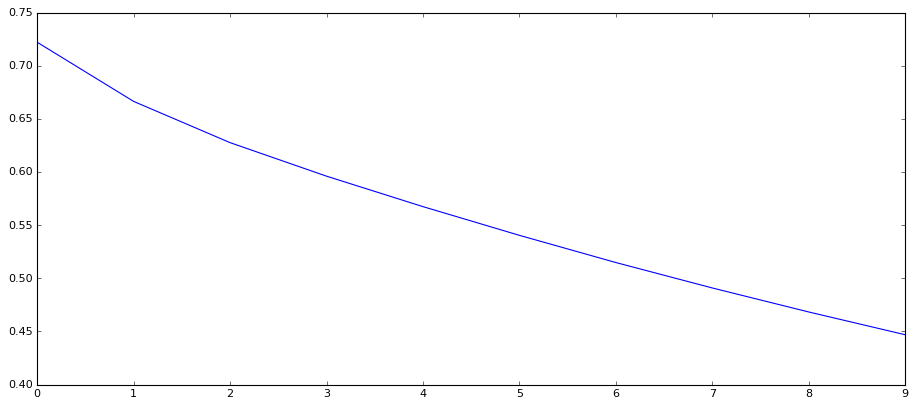

In [31]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(lr.losses)
ax.plot(range(0,size), lr.losses, '-', color='blue', animated = True, linewidth=1)

Now let’s examine whether we are getting good results. Note: best practice is to use a training and a test data set for this which we’ve omitted here for simplicity

In [32]:
score(data_healthy_scaled)

array([[ 0.62850142],
       [ 0.6514374 ],
       [ 0.67169082]], dtype=float32)

In [33]:
score(data_broken_scaled)

array([[ 0.34999403],
       [ 0.31863785],
       [ 0.36547723]], dtype=float32)

Let’s create a python queue for our data

In [35]:
q = Queue(7000)

To subscribe to real time data, we need to specify a callback handler where we extract and reformat the data, register the callback handler to the MQTT client and select the type of events we want to subscribe to


In [38]:
def doNN(data):
    global submit_work
    data_fft = np.fft.fft(data)
    data_scaled = scaleData(data_fft)
    data_scaled_reshaped = data_scaled
    data_scaled_reshaped.shape = (3, 3000)
    prediction = str(np.sum(score(data_scaled_reshaped))/3)
    print ("Prediction: %s, publishing..." % (prediction))
    myData={'healthy' : prediction}
    client.publishEvent("0.16.2", "lorenz", "status", "json", myData)
    if submit_work:
        submit_work = False
        parts_data["ZzEP8"] = json.dumps(myData)
        submitAll(email, secret, key, parts_data)
        print ("Submitting to grader: %s" % (json.dumps(myData)))
    print ("Done")

Now it’s time to start the endless loop to wait for data arriving in the queue. Once started please start generating data using the NodeRED test data generator. 

IMPORTANT: You are blocking the kernel now, so the only way to escape is to click on “Kernel->Restart & Clear Output” and wait until all outputs disappear. Then you can start over from scratch. 

You can also choose “Cell->Run all”

Rarely you might get an “memory error”, in case too many students on the free tier are pushing load to the underlying Kubernetes engine. So, in that case just start over as described above by restarting the kernel and run all again WITHOUT using the “Run all” method, just run each cell, one by one and wait until it has completed (by waiting for the asterisk being replaced by a number)

In [ ]:
import numpy as np
while True:
    while not q.empty():
        sys.stdout.write('.')
        sys.stdout.flush()
        point =q.get()
        try:
            data
        except NameError:
            data = np.array(point)
            data = data.astype(float)
            print(data.dtype)
            
        else:
            data = np.append(data,point)
        if data.size>=9000:
            data = np.reshape(data,(3000,3))
            print ("Sending window downstream to the neural network...")
            doNN(data)
            print ("Training finished...")
            del data


.float64
...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

/usr/local/src/bluemix_jupyter_bundle.v101/notebook/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype complex128 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Something went wrong, please have a look at the reponse of the grader
-------------------------
{"errorCode":"invalidEmailOrToken","message":"Invalid email or token.","details":{"learnerMessage":"You used an invalid email or your token may have expired. Please make sure you have entered all fields correctly. Try generating a new token if the issue still persists."}}
-------------------------
Submitting to grader: {"healthy": "0.417126814524"}
Done
Training finished...
.float64
...............................................................................................................................................................

In case you get some reshaping errors, just execute the following line and start over with the previous cell

In [ ]:
del data